In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10042459682794969053
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5326769902889371499
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [ ]:
data = pd.read_csv("/content/drive/My Drive/fer2013/fer2013.csv")

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data.shape

(35887, 3)

In [ ]:
emotion_map = {0: ' Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


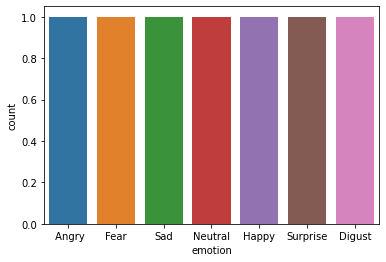

In [ ]:
import seaborn as sns
sns.countplot(emotion_counts['emotion'])

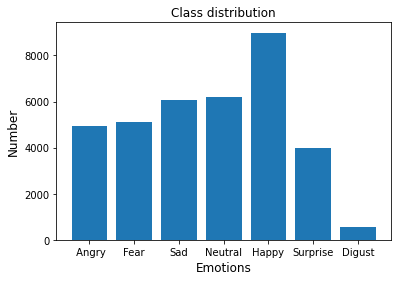

In [ ]:
pyplot.figure(figsize=(6, 4))
pyplot.bar(emotion_counts.emotion, emotion_counts.number)
pyplot.title('Class distribution')
pyplot.xlabel('Emotions', fontsize=12)
pyplot.ylabel('Number', fontsize=12)
pyplot.show()

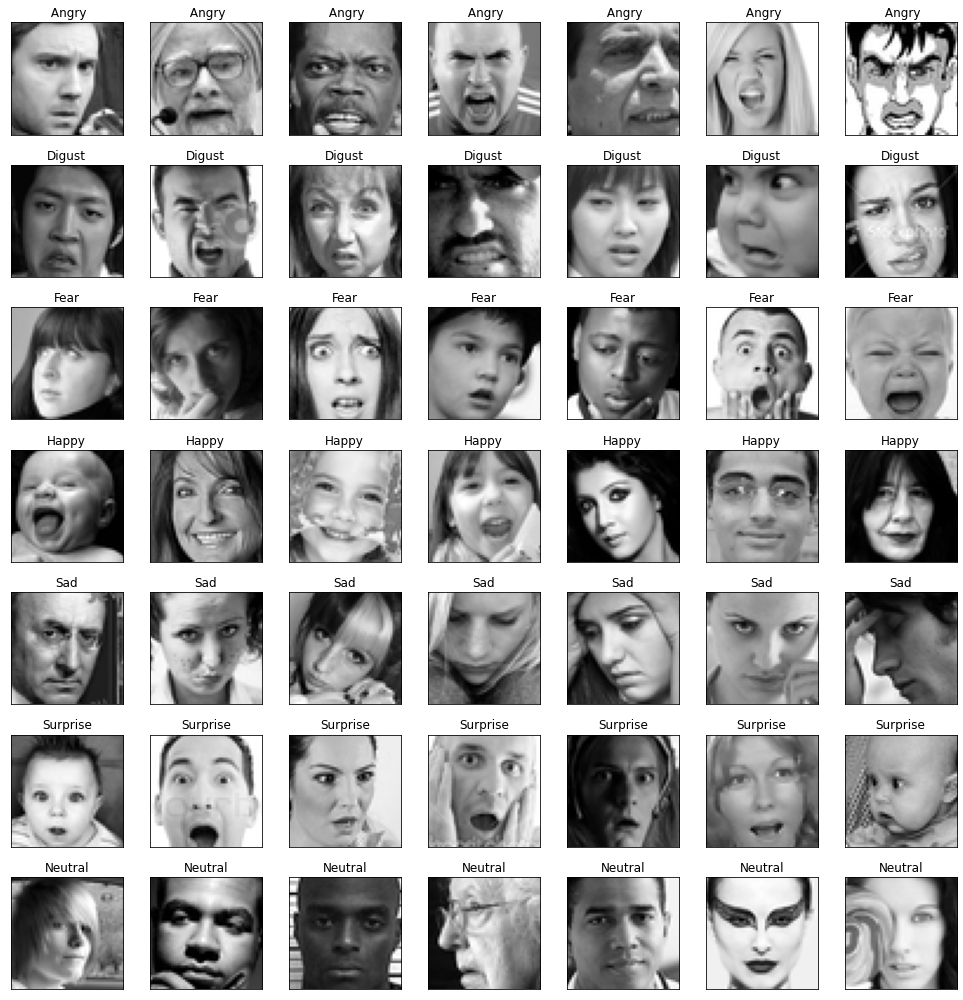

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(data.emotion.unique()):
    for j in range(7):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_map[label])
        pyplot.tight_layout()

In [ ]:
img_array = data.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(35887, 48, 48, 1)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(data.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.25, random_state=42)

In [ ]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
cnn_model = Sequential()

Input_shape = (48, 48, 1)

cnn_model = Sequential()


cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'elu', kernel_initializer='he_normal', padding='same',input_shape = Input_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'elu', kernel_initializer='he_normal',padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.3))


cnn_model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'elu', kernel_initializer='he_normal',padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'elu', kernel_initializer='he_normal',padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.4))

cnn_model.add(Flatten())

cnn_model.add(Dense(units = 1024, activation = 'relu', kernel_initializer='he_uniform'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(units = 512, activation = 'relu', kernel_initializer='he_uniform'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(units = 256, activation = 'relu', kernel_initializer='he_uniform'))
cnn_model.add(BatchNormalization())

cnn_model.add(Dense(units = 7, activation = 'softmax'))

In [ ]:
from tensorflow.keras.optimizers import Adam
cnn_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr=0.001,beta_1=0.9,beta_2=0.999), metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#4:21
history = cnn_model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/10
421/421 [==============================] - 20s 37ms/step - loss: 1.7464 - accuracy: 0.3449 - val_loss: 1.6434 - val_accuracy: 0.3752
Epoch 2/10
421/421 [==============================] - 16s 37ms/step - loss: 1.4075 - accuracy: 0.4565 - val_loss: 1.3301 - val_accuracy: 0.4955
Epoch 3/10
421/421 [==============================] - 15s 37ms/step - loss: 1.2885 - accuracy: 0.5072 - val_loss: 1.2465 - val_accuracy: 0.5300
Epoch 4/10
421/421 [==============================] - 15s 36ms/step - loss: 1.1971 - accuracy: 0.5427 - val_loss: 1.1877 - val_accuracy: 0.5488
Epoch 5/10
421/421 [==============================] - 15s 36ms/step - loss: 1.1332 - accuracy: 0.5673 - val_loss: 1.1352 - val_accuracy: 0.5728
Epoch 6/10
421/421 [==============================] - 15s 37ms/step - loss: 1.0667 - accuracy: 0.5952 - val_loss: 1.1141 - val_accuracy: 0.5882
Epoch 7/10
421/421 [==============================] - 15s 36ms/step - loss: 1.0091 - accuracy: 0.6179 - val_loss: 1.1279 - val_accuracy:

In [ ]:
loss, accuracy = cnn_model.evaluate(X_valid, y_valid)
loss_train, accuracy_train = cnn_model.evaluate(X_train, y_train)
print('Test accuracy is: ', accuracy)
print("Test loss is    : ", loss)

print("Train accuracy is: ", accuracy_train)
print("Train loss is: ", loss_train)

842/842 [==============================] - 6s 7ms/step - loss: 0.4882 - accuracy: 0.8362
Test accuracy is:  0.6024298071861267
Test loss is    :  1.1365227699279785
Train accuracy is:  0.8361508250236511
Train loss is:  0.48824793100357056


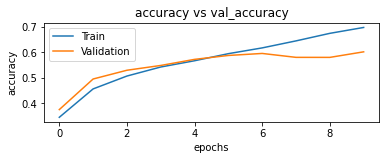

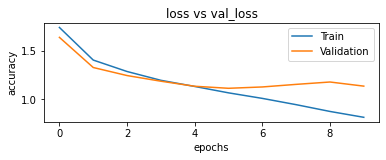

In [ ]:
pyplot.subplot(211)
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('accuracy vs val_accuracy')
pyplot.xlabel('epochs')
pyplot.ylabel('accuracy')
pyplot.legend(['Train', 'Validation'])
pyplot.show()

pyplot.subplot(212)
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('loss vs val_loss')
pyplot.xlabel('epochs')
pyplot.ylabel('accuracy')
pyplot.legend(['Train', 'Validation'])
pyplot.show()